### <b> PySpark vs GCP </b>

#### <b> PySpark </b>

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when, datediff, hour, minute, count, avg, stddev, min, max, desc, countDistinct, sum as spark_sum, max as spark_max
import os
import time
import matplotlib.pyplot as plt

In [89]:
time_markings_spark = {
    "load": [],
    "query": [],
}

In [3]:
import psutil

# Print your system's available memory
mem_info = psutil.virtual_memory()
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")

Total memory: 18.00 GB
Available memory: 9.28 GB


* <b> Java is required: </b> brew install openjdk@11 (MacOs) OR sudo apt install openjdk-11-jdk (Ubuntu)


#### <b> Spark and CSV data loading functions </b>

In [ ]:
# spark.driver.memory: Used by the main program that orchestrates tasks (Stores task results, coordinates actions, loads final DataFrames)
# spark.executor.memory: Used by worker processes that execute individual tasks (Data processing, transformations, aggregations, shuffling)
# spark.driver.maxResultSize: limits the total size of serialized results that can be returned to the driver from all partitions in a single Spark operation
def initialize_spark():
    '''
    Description: Initialize Spark Session

    Arguments: 
        -None
    Output: 
        -Spark session
    '''
    spark = SparkSession.builder \
                        .appName("MIMIC-III LOS Prediction") \
                        .config("spark.driver.memory", "12g") \
                        .config("spark.executor.memory", "12g") \
                        .config("spark.driver.maxResultSize", "6g") \
                        .getOrCreate()

    # Check initialization
    print("Success! Spark is working.")
    print(f"Spark version: {spark.version}\n")

    return spark

def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")
    
    print(f"Loading {table_name} from CSV...")
    start_time = time.time()
    
    
    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    
    # Force action to measure full load time
    count = df.count()
    end_time = time.time()
    
    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [90]:
def load_csv_table(spark, csv_dir, table_name):
    """Load a CSV table with performance timing."""
    csv_path = os.path.join(csv_dir, f"{table_name.upper()}.csv")

    print(f"Loading {table_name} from CSV...")
    start_time = time.time()


    df = spark.read.csv(csv_path, header=True, inferSchema=True)
    df = df.drop("ROW_ID")
    count = df.count()
    end_time = time.time()
    totalTime = end_time - start_time
    time_markings_spark["load"].append(totalTime)

    print(f"Loaded {table_name}: {count} rows in {end_time - start_time:.2f} seconds")
    return df

In [93]:
spark = initialize_spark()

init_time = time.time()

# Load tables
admissions_df = load_csv_table(spark, "../data/raw", "admissions")
print("\n")
callout_df = load_csv_table(spark, "../data/raw", "callout")
print("\n")
chart_events_df = load_csv_table(spark, "../data/raw", "chartevents")
print("\n")
d_icd_diagnoses = load_csv_table(spark, "../data/raw", "d_icd_diagnoses")
print("\n")
d_items_df = load_csv_table(spark, "../data/raw", "d_items")
print("\n")
diagnoses_icd_df = load_csv_table(spark, "../data/raw", "diagnoses_icd")
print("\n")
icustays_df = load_csv_table(spark, "../data/raw", "icustays")
print("\n")
patients_df = load_csv_table(spark, "../data/raw", "patients")
print("\n")
services_df = load_csv_table(spark, "../data/raw", "services")
print("\n")

final_time = time.time() - init_time

print(f"Total loading time: {final_time}")

Success! Spark is working.
Spark version: 3.5.5

Loading admissions from CSV...
Loaded admissions: 58976 rows in 0.34 seconds


Loading callout from CSV...
Loaded callout: 34499 rows in 0.24 seconds


Loading chartevents from CSV...


Loaded chartevents: 330712483 rows in 101.22 seconds


Loading d_icd_diagnoses from CSV...
Loaded d_icd_diagnoses: 14567 rows in 0.08 seconds


Loading d_items from CSV...
Loaded d_items: 12487 rows in 0.06 seconds


Loading diagnoses_icd from CSV...
Loaded diagnoses_icd: 651047 rows in 0.28 seconds


Loading icustays from CSV...
Loaded icustays: 61532 rows in 0.16 seconds


Loading patients from CSV...
Loaded patients: 46520 rows in 0.12 seconds


Loading services from CSV...
Loaded services: 73343 rows in 0.15 seconds


Total loading time: 102.65047717094421


In [6]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

#### <b> Join tables based on the MIMIC-III dataset structure</b>

* 1 patient can have multiple ICU stays and Admissions
* We can extract total Hospital LOS by subtracting DISCHTIME to ADMITTIME
* We also can extract total ICU LOS

In [7]:
# Let's examine the multiple ICU stays situation
def analyze_multiple_icu_stays(icustays_df):
    """
    Analyze patterns of multiple ICU stays in the dataset.
    """
    print("=== Analysis of Multiple ICU Stays ===")
    
    # Total ICU stays
    total_stays = icustays_df.count()
    print(f"Total ICU stays: {total_stays}")
    
    # Unique patients
    unique_patients = icustays_df.select("SUBJECT_ID").distinct().count()
    print(f"Unique patients: {unique_patients}")
    
    # Unique hospital admissions
    unique_admissions = icustays_df.select("HADM_ID").distinct().count()
    print(f"Unique hospital admissions: {unique_admissions}")
    
    # Patients with multiple ICU stays (any combination)
    patients_multiple_stays = icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_count")) \
        .filter("icu_stays_count > 1")
    
    multiple_stays_count = patients_multiple_stays.count()
    print(f"Patients with multiple ICU stays: {multiple_stays_count}")
    
    # Distribution of ICU stays per patient
    print("\nDistribution of ICU stays per patient:")
    icustays_df.groupBy("SUBJECT_ID") \
        .agg(count("ICUSTAY_ID").alias("stays_count")) \
        .groupBy("stays_count") \
        .agg(count("SUBJECT_ID").alias("patient_count")) \
        .orderBy("stays_count") \
        .show()
    
    
    # Multiple ICU stays within same hospital admission
    same_admission_multiple = icustays_df.groupBy("HADM_ID") \
        .agg(count("ICUSTAY_ID").alias("icu_stays_in_admission")) \
        .filter("icu_stays_in_admission > 1")
    
    same_admission_count = same_admission_multiple.count()
    print(f"Hospital admissions with multiple ICU stays: {same_admission_count}")
    
    # Show examples
    print("\nExamples of patients with multiple ICU stays:")
    icustays_df.join(patients_multiple_stays.limit(3), "SUBJECT_ID") \
        .select("SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "LOS") \
        .orderBy("SUBJECT_ID", "INTIME") \
        .show(truncate=False)
    
    return {
        "total_stays": total_stays,
        "unique_patients": unique_patients,
        "patients_with_multiple_stays": multiple_stays_count,
        "admissions_with_multiple_icu_stays": same_admission_count
    }



# Run the analysis
stats = analyze_multiple_icu_stays(icustays_df)

=== Analysis of Multiple ICU Stays ===
Total ICU stays: 61532
Unique patients: 46476
Unique hospital admissions: 57786
Patients with multiple ICU stays: 8755

Distribution of ICU stays per patient:
+-----------+-------------+
|stays_count|patient_count|
+-----------+-------------+
|          1|        37721|
|          2|         5796|
|          3|         1619|
|          4|          650|
|          5|          300|
|          6|          151|
|          7|           86|
|          8|           44|
|          9|           29|
|         10|           19|
|         11|           15|
|         12|           11|
|         13|            8|
|         14|            4|
|         15|            6|
|         16|            2|
|         17|            2|
|         18|            2|
|         20|            1|
|         21|            2|
+-----------+-------------+
only showing top 20 rows

Hospital admissions with multiple ICU stays: 3260

Examples of patients with multiple ICU stays:
+------

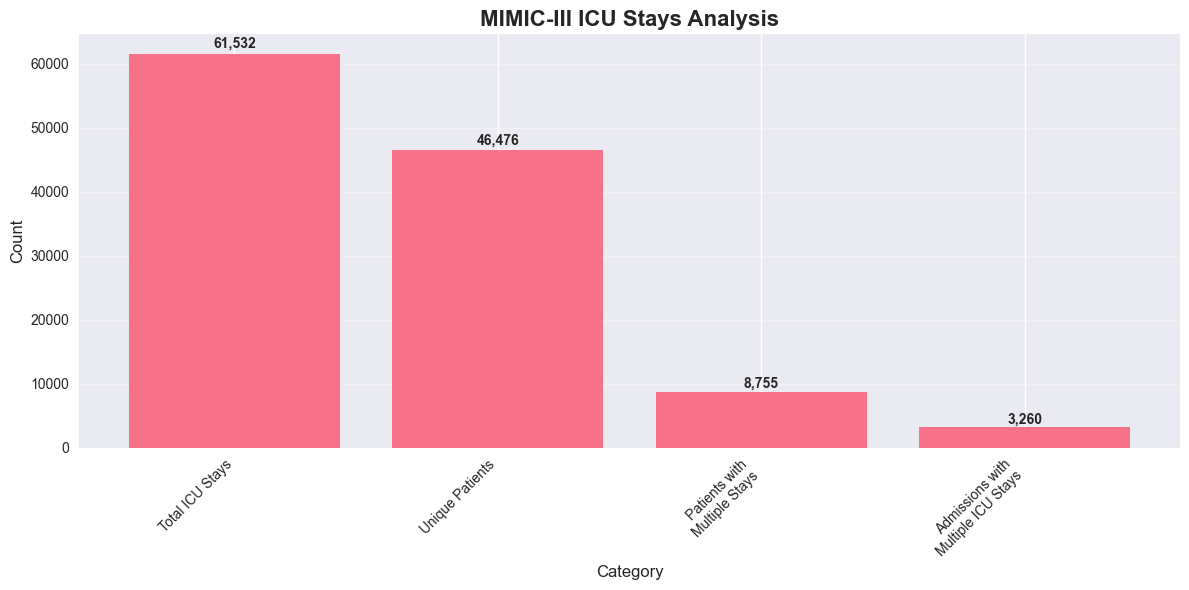

In [8]:
import matplotlib.pyplot as plt

xx = []
total_stays = stats["total_stays"]
xx.append(total_stays)
unique_patients = stats["unique_patients"]
xx.append(unique_patients)
patients_with_multiple_stays = stats["patients_with_multiple_stays"]
xx.append(patients_with_multiple_stays)
admissions_with_multiple_icu_stays = stats["admissions_with_multiple_icu_stays"]
xx.append(admissions_with_multiple_icu_stays)

# Create labels for the x-axis
labels = ['Total ICU Stays', 'Unique Patients', 'Patients with\nMultiple Stays', 'Admissions with\nMultiple ICU Stays']
# Create values for the y-axis (your actual data)
values = xx

# Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values)

# Add value labels on top of each bar - using a fixed offset instead of percentage
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Customize the plot
plt.title('MIMIC-III ICU Stays Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)

# Rotate x-axis labels if needed for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
stats

{'total_stays': 61532,
 'unique_patients': 46476,
 'patients_with_multiple_stays': 8755,
 'admissions_with_multiple_icu_stays': 3260}

Let's join <b> ICUSTAYS and ADMISSIONS </b> table to get relevant information from patients that were admitted to the ICU when they went to the hospital, and exclude those that didn't

In [10]:
new_icustays_df = icustays_df.join(admissions_df, on=["SUBJECT_ID", "HADM_ID"], how="left")

ICU STAYS + ADMISSIONS DATA ANALYSIS
Total records after join: 61,532
Null values in SUBJECT_ID: 0
Null values in HADM_ID: 0
Null values in ICUSTAY_ID: 0
Null values in INTIME: 0
Null values in OUTTIME: 10
Null values in ADMITTIME: 0
Null values in DISCHTIME: 0

Converting sample to Pandas for analysis...


25/06/03 18:16:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/var/folders/vw/fb5g0yw578jfpvmgdl2bgkr80000gn/T/ipykernel_9117/926561592.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(los_by_admission, labels=admission_types)
/var/folders/vw/fb5g0yw578jfpvmgdl2bgkr80000gn/T/ipykernel_9117/926561592.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([survived, died], labels=['Survived', 'Died'])


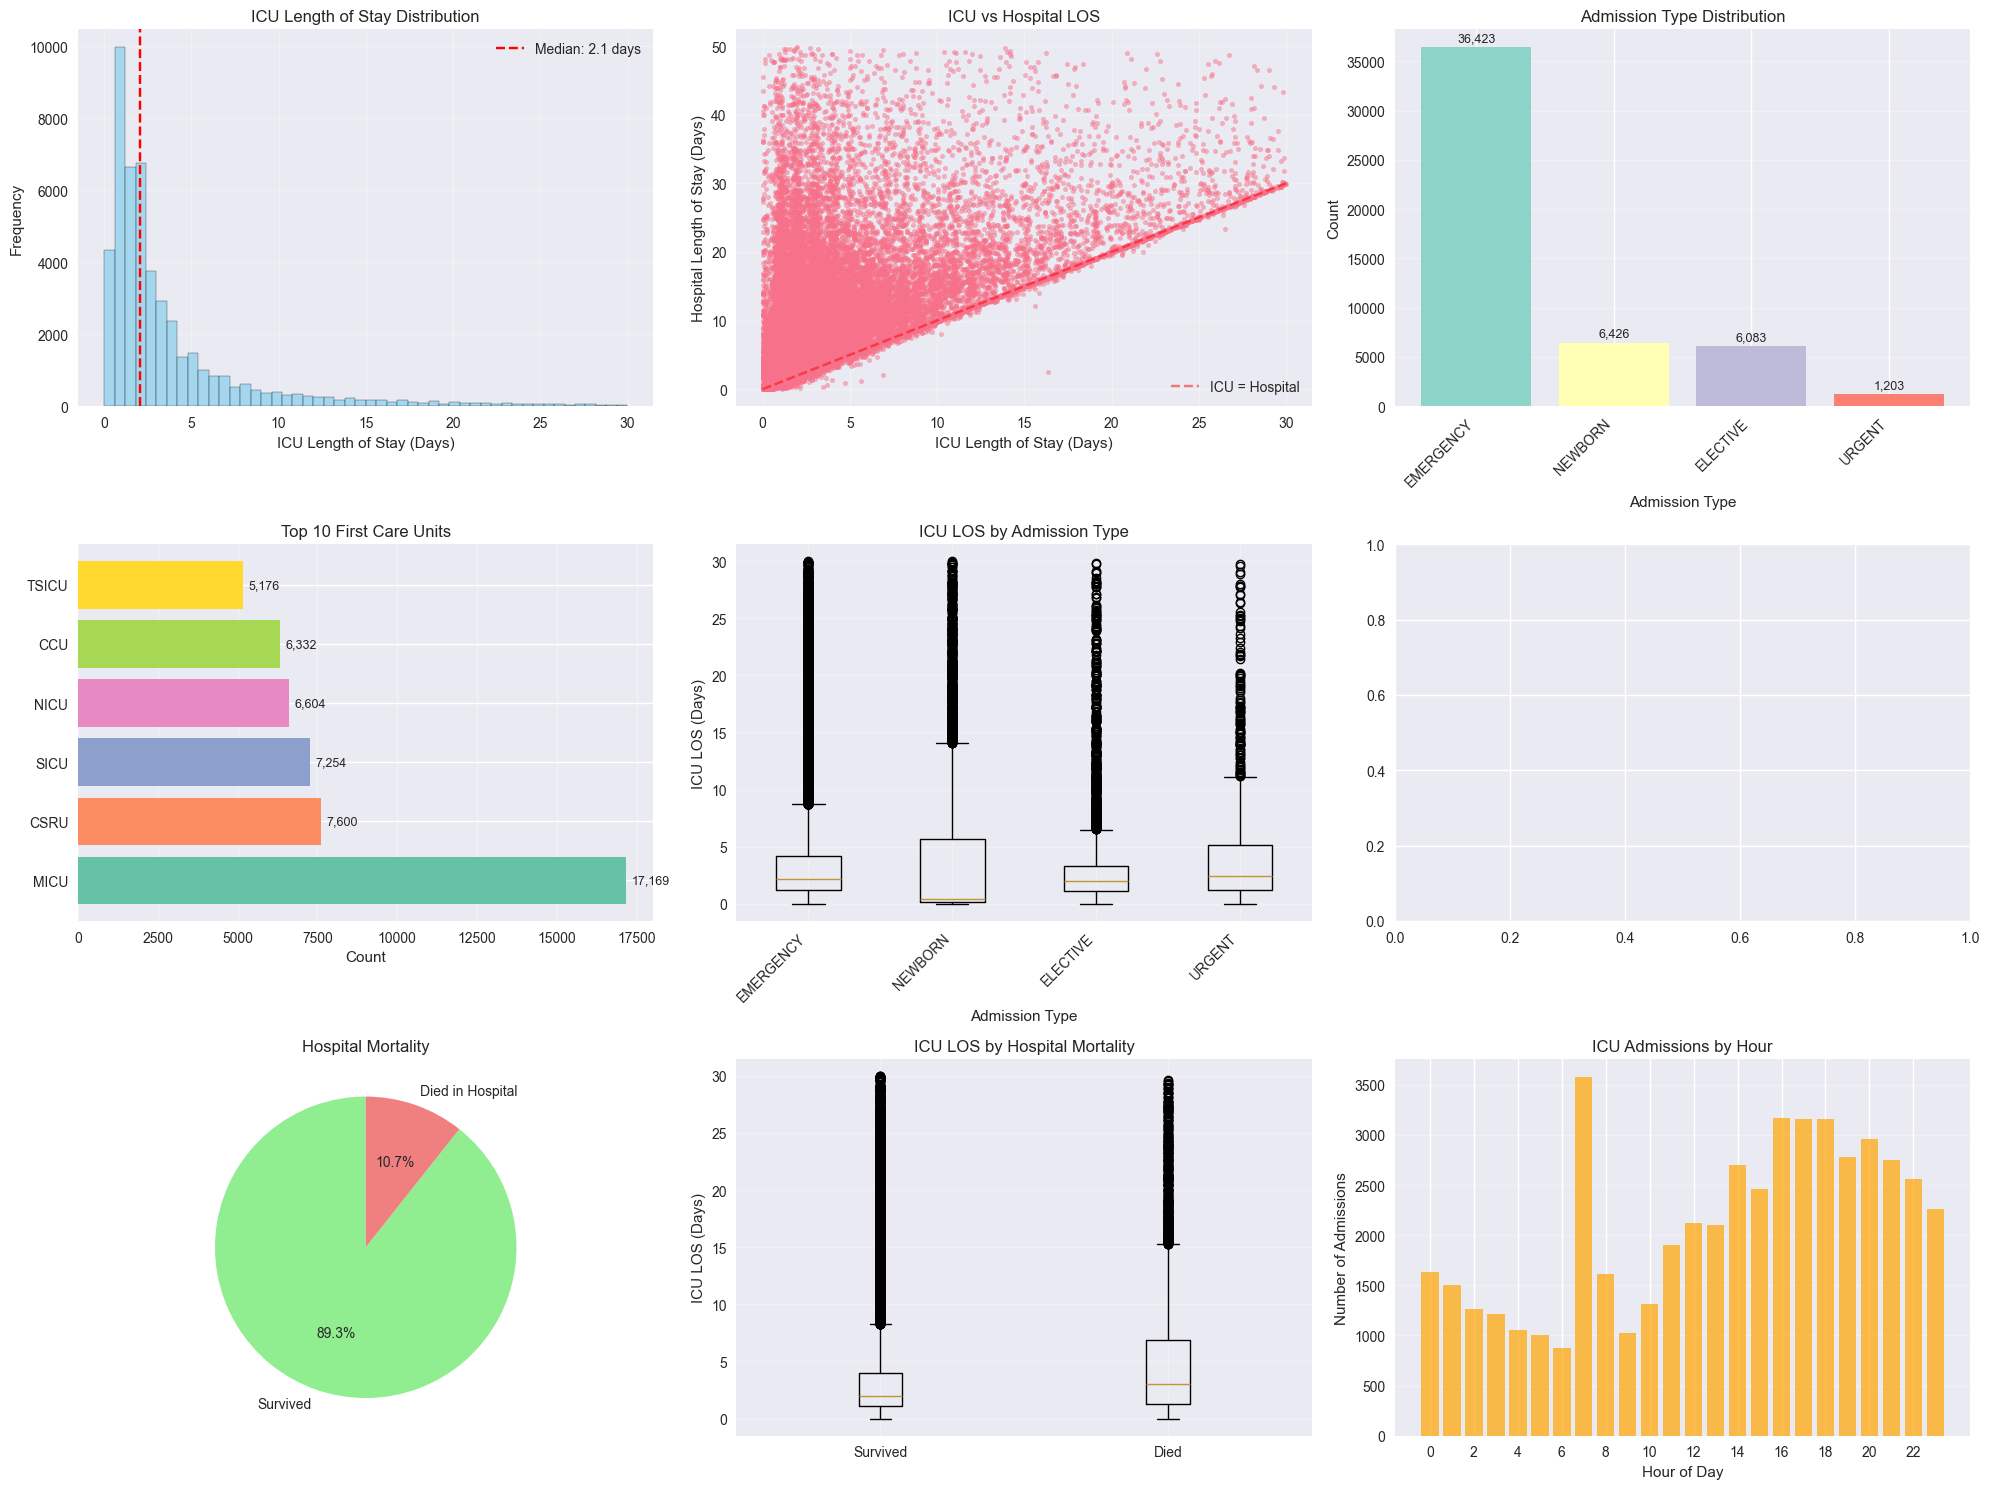


SUMMARY STATISTICS

ICU Length of Stay (Days):
  Mean: 4.93
  Median: 2.10
  Std: 9.61
  Min: 0.00
  Max: 173.07

Hospital Mortality Rate: 10.7%

Most common admission types:
  1. EMERGENCY: 36,423 (72.6%)
  2. NEWBORN: 6,426 (12.8%)
  3. ELECTIVE: 6,083 (12.1%)


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col, count, avg, min as spark_min, max as spark_max, stddev, when, isnan, isnull
from datetime import datetime

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def analyze_icustay_admission_join(new_icustays_df):
    """
    Comprehensive analysis of the ICU stays + admissions joined data
    """
    print("="*60)
    print("ICU STAYS + ADMISSIONS DATA ANALYSIS")
    print("="*60)
    
    # 1. Basic join statistics
    total_records = new_icustays_df.count()
    print(f"Total records after join: {total_records:,}")
    
    # Check for null values in key columns
    key_columns = ["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "INTIME", "OUTTIME", "ADMITTIME", "DISCHTIME"]
    null_counts = {}
    for col_name in key_columns:
        if col_name in new_icustays_df.columns:
            null_count = new_icustays_df.filter(col(col_name).isNull()).count()
            null_counts[col_name] = null_count
            print(f"Null values in {col_name}: {null_count:,}")
    
    # Convert to Pandas for detailed analysis and visualization
    print("\nConverting sample to Pandas for analysis...")
    
    # Sample for analysis (adjust size based on your memory)
    sample_size = 50000 if total_records > 50000 else total_records  # Adjust as needed
    sample_df = new_icustays_df.sample(fraction=sample_size/total_records, seed=42).toPandas()
    
    # Convert datetime columns
    datetime_cols = ['INTIME', 'OUTTIME', 'ADMITTIME', 'DISCHTIME', 'DOB', 'DOD']
    for col_name in datetime_cols:
        if col_name in sample_df.columns:
            sample_df[col_name] = pd.to_datetime(sample_df[col_name], errors='coerce')
    
    # Calculate lengths of stay
    if 'INTIME' in sample_df.columns and 'OUTTIME' in sample_df.columns:
        sample_df['ICU_LOS_HOURS'] = (sample_df['OUTTIME'] - sample_df['INTIME']).dt.total_seconds() / 3600
        sample_df['ICU_LOS_DAYS'] = sample_df['ICU_LOS_HOURS'] / 24
    
    if 'ADMITTIME' in sample_df.columns and 'DISCHTIME' in sample_df.columns:
        sample_df['HOSPITAL_LOS_HOURS'] = (sample_df['DISCHTIME'] - sample_df['ADMITTIME']).dt.total_seconds() / 3600
        sample_df['HOSPITAL_LOS_DAYS'] = sample_df['HOSPITAL_LOS_HOURS'] / 24
    
    # Create visualizations
    fig = plt.figure(figsize=(20, 15))
    
    # 1. ICU Length of Stay Distribution
    plt.subplot(3, 3, 1)
    if 'ICU_LOS_DAYS' in sample_df.columns:
        # Remove outliers for better visualization
        los_clean = sample_df['ICU_LOS_DAYS'].dropna()
        los_clean = los_clean[(los_clean > 0) & (los_clean < 30)]  # Focus on reasonable range
        
        plt.hist(los_clean, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('ICU Length of Stay (Days)')
        plt.ylabel('Frequency')
        plt.title('ICU Length of Stay Distribution')
        plt.axvline(los_clean.median(), color='red', linestyle='--', label=f'Median: {los_clean.median():.1f} days')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 2. Hospital vs ICU Length of Stay
    plt.subplot(3, 3, 2)
    if 'ICU_LOS_DAYS' in sample_df.columns and 'HOSPITAL_LOS_DAYS' in sample_df.columns:
        # Clean data for scatter plot
        plot_data = sample_df[['ICU_LOS_DAYS', 'HOSPITAL_LOS_DAYS']].dropna()
        plot_data = plot_data[(plot_data['ICU_LOS_DAYS'] > 0) & (plot_data['ICU_LOS_DAYS'] < 30) & 
                             (plot_data['HOSPITAL_LOS_DAYS'] > 0) & (plot_data['HOSPITAL_LOS_DAYS'] < 50)]
        
        plt.scatter(plot_data['ICU_LOS_DAYS'], plot_data['HOSPITAL_LOS_DAYS'], 
                   alpha=0.5, s=10)
        plt.xlabel('ICU Length of Stay (Days)')
        plt.ylabel('Hospital Length of Stay (Days)')
        plt.title('ICU vs Hospital LOS')
        
        # Add diagonal line (ICU = Hospital would be impossible, but shows relationship)
        max_icu = plot_data['ICU_LOS_DAYS'].max()
        max_hosp = plot_data['HOSPITAL_LOS_DAYS'].max()
        max_val = max_icu if max_icu < max_hosp else max_hosp
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='ICU = Hospital')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 3. Admission Type Distribution
    plt.subplot(3, 3, 3)
    if 'ADMISSION_TYPE' in sample_df.columns:
        admission_counts = sample_df['ADMISSION_TYPE'].value_counts()
        colors = plt.cm.Set3(range(len(admission_counts)))
        bars = plt.bar(range(len(admission_counts)), admission_counts.values, color=colors)
        plt.xlabel('Admission Type')
        plt.ylabel('Count')
        plt.title('Admission Type Distribution')
        plt.xticks(range(len(admission_counts)), admission_counts.index, rotation=45, ha='right')
        
        # Add value labels
        max_count = admission_counts.max()
        for bar, value in zip(bars, admission_counts.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_count*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
        plt.grid(axis='y', alpha=0.3)
    
    # 4. First Care Unit Distribution
    plt.subplot(3, 3, 4)
    if 'FIRST_CAREUNIT' in sample_df.columns:
        careunit_counts = sample_df['FIRST_CAREUNIT'].value_counts().head(10)  # Top 10
        colors = plt.cm.Set2(range(len(careunit_counts)))
        bars = plt.barh(range(len(careunit_counts)), careunit_counts.values, color=colors)
        plt.yticks(range(len(careunit_counts)), careunit_counts.index)
        plt.xlabel('Count')
        plt.title('Top 10 First Care Units')
        
        # Add value labels
        max_careunit = careunit_counts.max()
        for bar, value in zip(bars, careunit_counts.values):
            plt.text(bar.get_width() + max_careunit*0.01, bar.get_y() + bar.get_height()/2,
                    f'{value:,}', ha='left', va='center', fontsize=9)
        plt.grid(axis='x', alpha=0.3)
    
    # 5. LOS by Admission Type
    plt.subplot(3, 3, 5)
    if 'ADMISSION_TYPE' in sample_df.columns and 'ICU_LOS_DAYS' in sample_df.columns:
        los_by_admission = []
        admission_types = []
        
        for admission_type in sample_df['ADMISSION_TYPE'].dropna().unique():
            los_subset = sample_df[sample_df['ADMISSION_TYPE'] == admission_type]['ICU_LOS_DAYS'].dropna()
            los_subset = los_subset[(los_subset > 0) & (los_subset < 30)]
            if len(los_subset) > 10:  # Only include types with sufficient data
                los_by_admission.append(los_subset)
                admission_types.append(admission_type)
        
        if los_by_admission:
            plt.boxplot(los_by_admission, labels=admission_types)
            plt.xlabel('Admission Type')
            plt.ylabel('ICU LOS (Days)')
            plt.title('ICU LOS by Admission Type')
            plt.xticks(rotation=45, ha='right')
            plt.grid(alpha=0.3)
    
    # 6. Age Distribution
    plt.subplot(3, 3, 6)
    if 'DOB' in sample_df.columns and 'ADMITTIME' in sample_df.columns:
        # Calculate age at admission
        sample_df['AGE_AT_ADMISSION'] = (sample_df['ADMITTIME'] - sample_df['DOB']).dt.days / 365.25
        
        # Handle age > 89 (MIMIC-III shifts these to 300+)
        ages = sample_df['AGE_AT_ADMISSION'].dropna()
        ages_clean = ages[ages < 120]  # Remove shifted ages
        
        plt.hist(ages_clean, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
        plt.xlabel('Age at Admission (Years)')
        plt.ylabel('Frequency')
        plt.title('Age Distribution at ICU Admission')
        plt.axvline(ages_clean.median(), color='red', linestyle='--', 
                   label=f'Median: {ages_clean.median():.1f} years')
        plt.legend()
        plt.grid(alpha=0.3)
    
    # 7. Mortality Analysis
    plt.subplot(3, 3, 7)
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns:
        mortality_counts = sample_df['HOSPITAL_EXPIRE_FLAG'].value_counts()
        labels = ['Survived', 'Died in Hospital']
        colors = ['lightgreen', 'lightcoral']
        
        plt.pie(mortality_counts.values, labels=labels, colors=colors, autopct='%1.1f%%',
               startangle=90)
        plt.title('Hospital Mortality')
    
    # 8. LOS vs Mortality
    plt.subplot(3, 3, 8)
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns and 'ICU_LOS_DAYS' in sample_df.columns:
        survived = sample_df[sample_df['HOSPITAL_EXPIRE_FLAG'] == 0]['ICU_LOS_DAYS'].dropna()
        died = sample_df[sample_df['HOSPITAL_EXPIRE_FLAG'] == 1]['ICU_LOS_DAYS'].dropna()
        
        # Clean data
        survived = survived[(survived > 0) & (survived < 30)]
        died = died[(died > 0) & (died < 30)]
        
        plt.boxplot([survived, died], labels=['Survived', 'Died'])
        plt.ylabel('ICU LOS (Days)')
        plt.title('ICU LOS by Hospital Mortality')
        plt.grid(alpha=0.3)
    
    # 9. Admission Pattern by Hour
    plt.subplot(3, 3, 9)
    if 'ADMITTIME' in sample_df.columns:
        admission_hours = sample_df['ADMITTIME'].dt.hour
        hour_counts = admission_hours.value_counts().sort_index()
        
        plt.bar(hour_counts.index, hour_counts.values, color='orange', alpha=0.7)
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Admissions')
        plt.title('ICU Admissions by Hour')
        plt.xticks(range(0, 24, 2))
        plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    if 'ICU_LOS_DAYS' in sample_df.columns:
        los_stats = sample_df['ICU_LOS_DAYS'].describe()
        print(f"\nICU Length of Stay (Days):")
        print(f"  Mean: {los_stats['mean']:.2f}")
        print(f"  Median: {los_stats['50%']:.2f}")
        print(f"  Std: {los_stats['std']:.2f}")
        print(f"  Min: {los_stats['min']:.2f}")
        print(f"  Max: {los_stats['max']:.2f}")
    
    if 'HOSPITAL_EXPIRE_FLAG' in sample_df.columns:
        mortality_rate = sample_df['HOSPITAL_EXPIRE_FLAG'].mean() * 100
        print(f"\nHospital Mortality Rate: {mortality_rate:.1f}%")
    
    if 'ADMISSION_TYPE' in sample_df.columns:
        print(f"\nMost common admission types:")
        for i, (admission_type, count) in enumerate(sample_df['ADMISSION_TYPE'].value_counts().head(3).items()):
            print(f"  {i+1}. {admission_type}: {count:,} ({count/len(sample_df)*100:.1f}%)")
    
    return sample_df

# Usage:
sample_analysis = analyze_icustay_admission_join(new_icustays_df)

Now we join the <b> complete ICU data with the PATIENTS info </b>

In [12]:
patients_full_info_df = new_icustays_df.join(patients_df, on="SUBJECT_ID", how="left")

In [13]:
columns=["DOD_HOSP", "DOD_SSN"]
patients_full_info_df = patients_full_info_df.drop(*columns) # redundant since DOD column gives us the same info

In [14]:
patients_full_info_df.show(5)

+----------+-------+----------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------+-----------------+--------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|   LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|LANGUAGE|         RELIGION|MARITAL_STATUS|           ETHNICITY|          EDREGTIME|          EDOUTTIME|           DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|
+-------

In [15]:
# Check if row counts are the same
print(f"ICUSTAYS count: {icustays_df.count()}")
print(f"After joining ADMISSIONS: {new_icustays_df.count()}")
print(f"After joining PATIENTS: {patients_full_info_df.count()}")


ICUSTAYS count: 61532
After joining ADMISSIONS: 61532
After joining PATIENTS: 61532


In [16]:
d_icd_diagnoses.show(5)

+---------+--------------------+--------------------+
|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+---------+--------------------+--------------------+
|    01166|TB pneumonia-oth ...|Tuberculous pneum...|
|    01170|TB pneumothorax-u...|Tuberculous pneum...|
|    01171|TB pneumothorax-n...|Tuberculous pneum...|
|    01172|TB pneumothorx-ex...|Tuberculous pneum...|
|    01173|TB pneumothorax-m...|Tuberculous pneum...|
+---------+--------------------+--------------------+
only showing top 5 rows



Join the <b> DIAGNOSES and D_ICD_DIAGNOSES tables </b> to get diagnoses descriptions based on the ICD9 code

In [17]:
full_diagnosis_data = diagnoses_icd_df.join(d_icd_diagnoses, on="ICD9_CODE", how="left")
full_diagnosis_data = full_diagnosis_data.drop("SHORT_TITLE")

Check total distinct number of diagnosis

In [18]:
full_diagnosis_data.select("ICD9_CODE").distinct().count()

6985

In [19]:
p_268 = full_diagnosis_data[full_diagnosis_data["SUBJECT_ID"]==268]

In [20]:
p_268.show() # 1 patient can have multiple diagnoses for the same HADM

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    48241|       268| 110404|      1|Methicillin susce...|
|     4280|       268| 110404|      2|Congestive heart ...|
|    51881|       268| 110404|      3|Acute respiratory...|
|     5845|       268| 110404|      4|Acute kidney fail...|
|     4275|       268| 110404|      5|      Cardiac arrest|
|     0389|       268| 110404|      6|Unspecified septi...|
|    49322|       268| 110404|      7|Chronic obstructi...|
|     2761|       268| 110404|      8|Hyposmolality and...|
|     4271|       268| 110404|      9|Paroxysmal ventri...|
+---------+----------+-------+-------+--------------------+



In [21]:
yo = p_268[p_268["SEQ_NUM"]==1]

In [22]:
title = yo["LONG_TITLE"]

In [23]:
yo.select("LONG_TITLE").collect()[0][0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [24]:
yo.select("LONG_TITLE").first()[0]

'Methicillin susceptible pneumonia due to Staphylococcus aureus'

In [25]:
full_diagnosis_data.show(5)

+---------+----------+-------+-------+--------------------+
|ICD9_CODE|SUBJECT_ID|HADM_ID|SEQ_NUM|          LONG_TITLE|
+---------+----------+-------+-------+--------------------+
|    40301|       109| 172335|      1|Hypertensive chro...|
|      486|       109| 172335|      2|Pneumonia, organi...|
|    58281|       109| 172335|      3|Chronic glomerulo...|
|     5855|       109| 172335|      4|Chronic kidney di...|
|     4254|       109| 172335|      5|Other primary car...|
+---------+----------+-------+-------+--------------------+
only showing top 5 rows



Now join <b> PATIENT and DIAGNOSES </b> data

In [26]:
patients_full_info_df = patients_full_info_df.join(full_diagnosis_data, on=["SUBJECT_ID","HADM_ID"], how="left")

In [27]:
patients_full_info_df.show(5)

+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+--------+--------------+------------------+-------------------+-------------------+---------+--------------------+--------------------+------+-------------------+-------------------+-----------+---------+-------+--------------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|  LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|RELIGION|MARITAL_STATUS|         ETHNICITY|          EDREGTIME|          EDOUTTIME|DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|ICD9_CODE|SEQ_NUM|      

In [28]:
distinct_diagnosis = patients_full_info_df.select("LONG_TITLE").distinct()

In [29]:
patients_full_info_df.count()

705921

In [30]:
# Get top N most frequent diagnoses
top_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .orderBy(desc("count")).limit(200)  # Top 200 covers ~80% of cases

In [31]:
rare_diagnoses = diagnoses_icd_df.groupBy("ICD9_CODE").count() \
    .filter(col("count") <= 4000) \
    .orderBy(desc("count"))

In [32]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

In [33]:
def create_icd9_code_based_diagnosis_features(patients_full_info_df):
    """
    Create diagnosis features based on actual ICD-9 code ranges.
    """
    print("Creating ICD-9 code-based diagnosis features...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # ICD-9 code-based diagnosis categories
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_infectious", 
                   when(col("ICD9_CODE").rlike("^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("ICD9_CODE").rlike("^(1[4-9][0-9]|2[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("ICD9_CODE").rlike("^(2[4-7][0-9])"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("ICD9_CODE").rlike("^(2[8-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("ICD9_CODE").rlike("^(29[0-9]|30[0-9]|31[0-9])"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("ICD9_CODE").rlike("^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])"), 1).otherwise(0)) \
        .withColumn("has_cardiovascular", 
                   when(col("ICD9_CODE").rlike("^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("ICD9_CODE").rlike("^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("ICD9_CODE").rlike("^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("ICD9_CODE").rlike("^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("ICD9_CODE").rlike("^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("ICD9_CODE").rlike("^(68[0-9]|69[0-9]|70[0-9])"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("ICD9_CODE").rlike("^(71[0-9]|72[0-9]|73[0-9])"), 1).otherwise(0)) \
        .withColumn("has_congenital", 
                   when(col("ICD9_CODE").rlike("^(74[0-9]|75[0-9])"), 1).otherwise(0)) \
        .withColumn("has_perinatal", 
                   when(col("ICD9_CODE").rlike("^(76[0-9]|77[0-9])"), 1).otherwise(0)) \
        .withColumn("has_symptoms_signs", 
                   when(col("ICD9_CODE").rlike("^(78[0-9]|79[0-9])"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("ICD9_CODE").rlike("^(8[0-9][0-9]|9[0-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_external_causes", 
                   when(col("ICD9_CODE").rlike("^(E[0-9])"), 1).otherwise(0)) \
        .withColumn("has_supplemental", 
                   when(col("ICD9_CODE").rlike("^(V[0-9])"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_congenital").alias("has_congenital"),
            spark_max("has_perinatal").alias("has_perinatal"),
            spark_max("has_symptoms_signs").alias("has_symptoms_signs"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_external_causes").alias("has_external_causes"),
            spark_max("has_supplemental").alias("has_supplemental"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
                     "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
                     "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
                     "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
                     "has_trauma", "has_external_causes", "has_supplemental", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"ICD-9 code-based diagnosis features created: {result.count()} rows")
    return result

In [34]:
diagnosis_bins_patient = create_icd9_code_based_diagnosis_features(patients_full_info_df=patients_full_info_df)

Creating ICD-9 code-based diagnosis features...
ICD-9 code-based diagnosis features created: 61532 rows


In [63]:
def create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df):
    """
    Create diagnosis features based on actual ICD-9 code ranges - FIXED VERSION
    """
    print("Creating ICD-9 code-based diagnosis features (fixed)...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # ICD-9 code-based diagnosis categories - FIXED V and E code patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_infectious", 
                   when(col("ICD9_CODE").rlike("^(001|002|003|004|005|006|007|008|009|01[0-9]|02[0-9]|03[0-9]|04[0-9]|05[0-9]|06[0-9]|07[0-9]|08[0-9]|09[0-9]|1[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("ICD9_CODE").rlike("^(1[4-9][0-9]|2[0-3][0-9])"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("ICD9_CODE").rlike("^(2[4-7][0-9])"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("ICD9_CODE").rlike("^(2[8-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("ICD9_CODE").rlike("^(29[0-9]|30[0-9]|31[0-9])"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("ICD9_CODE").rlike("^(32[0-9]|33[0-9]|34[0-9]|35[0-9]|36[0-9]|37[0-9]|38[0-9])"), 1).otherwise(0)) \
        .withColumn("has_cardiovascular", 
                   when(col("ICD9_CODE").rlike("^(39[0-9]|40[0-9]|41[0-9]|42[0-9]|43[0-9]|44[0-9]|45[0-9])"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("ICD9_CODE").rlike("^(46[0-9]|47[0-9]|48[0-9]|49[0-9]|50[0-9]|51[0-9])"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("ICD9_CODE").rlike("^(52[0-9]|53[0-9]|54[0-9]|55[0-9]|56[0-9]|57[0-9])"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("ICD9_CODE").rlike("^(58[0-9]|59[0-9]|60[0-9]|61[0-9]|62[0-9])"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("ICD9_CODE").rlike("^(63[0-9]|64[0-9]|65[0-9]|66[0-9]|67[0-9])"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("ICD9_CODE").rlike("^(68[0-9]|69[0-9]|70[0-9])"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("ICD9_CODE").rlike("^(71[0-9]|72[0-9]|73[0-9])"), 1).otherwise(0)) \
        .withColumn("has_congenital", 
                   when(col("ICD9_CODE").rlike("^(74[0-9]|75[0-9])"), 1).otherwise(0)) \
        .withColumn("has_perinatal", 
                   when(col("ICD9_CODE").rlike("^(76[0-9]|77[0-9])"), 1).otherwise(0)) \
        .withColumn("has_symptoms_signs", 
                   when(col("ICD9_CODE").rlike("^(78[0-9]|79[0-9])"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("ICD9_CODE").rlike("^(8[0-9][0-9]|9[0-9][0-9])"), 1).otherwise(0)) \
        .withColumn("has_external_causes", 
                   when(col("ICD9_CODE").rlike("^E"), 1).otherwise(0)) \
        .withColumn("has_supplemental", 
                   when(col("ICD9_CODE").rlike("^V"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_congenital").alias("has_congenital"),
            spark_max("has_perinatal").alias("has_perinatal"),
            spark_max("has_symptoms_signs").alias("has_symptoms_signs"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_external_causes").alias("has_external_causes"),
            spark_max("has_supplemental").alias("has_supplemental"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Rest of function remains the same...
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    diagnosis_cols = ["has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
                     "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
                     "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
                     "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
                     "has_trauma", "has_external_causes", "has_supplemental", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"ICD-9 code-based diagnosis features created: {result.count()} rows")
    return result

In [64]:
diagnosis_bins_patient_fixed = create_icd9_code_based_diagnosis_features_fixed(patients_full_info_df=patients_full_info_df)

Creating ICD-9 code-based diagnosis features (fixed)...
ICD-9 code-based diagnosis features created: 61532 rows


In [66]:
diagnosis_bins_patient_fixed.show()

+----------+----------+-------+----------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+----------+--------+-----------------+-----------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+------+-------------------+-------------------+-----------+--------------+--------------+-------------+---------------+---------------+----------------+------------------+---------------+--------------------+-----------------+-------------+--------+-------------------+--------------+-------------+------------------+----------+-------------------+----------------+---------------+
|ICUSTAY_ID|SUBJECT_ID|HADM_ID|  DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|    LOS|          ADMITTIME|          DISCH

In [61]:
patients_full_info_df.show(5)

+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-----+-------------------+-------------------+-------------------+--------------+--------------------+------------------+---------+--------+--------+--------------+------------------+-------------------+-------------------+---------+--------------------+--------------------+------+-------------------+-------------------+-----------+---------+-------+--------------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|            OUTTIME|  LOS|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|LANGUAGE|RELIGION|MARITAL_STATUS|         ETHNICITY|          EDREGTIME|          EDOUTTIME|DIAGNOSIS|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|GENDER|                DOB|                DOD|EXPIRE_FLAG|ICD9_CODE|SEQ_NUM|      

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col, sum as spark_sum

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

def visualize_diagnosis_categories(diagnosis_bins_patient_df):
    """
    Visualize the frequency of each diagnosis category from binned features
    
    Args:
        diagnosis_bins_patient_df: Spark DataFrame with binary diagnosis columns
    """
    
    print("Extracting diagnosis category frequencies...")
    
    # List of diagnosis columns (excluding total_diagnoses)
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    # Calculate sum for each diagnosis category
    category_counts = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        category_counts.append({
            'category': col_name.replace('has_', '').title(),
            'count': count if count is not None else 0
        })
    
    # Convert to DataFrame and sort by count
    category_df = pd.DataFrame(category_counts)
    category_df = category_df.sort_values('count', ascending=True)  # Ascending for horizontal bar chart
    
    # Get total patients for percentage calculation
    total_patients = diagnosis_bins_patient_df.count()
    category_df['percentage'] = (category_df['count'] / total_patients) * 100
    
    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('ICD-9 Diagnosis Categories - Patient Distribution', fontsize=16, fontweight='bold')
    
    # Plot 1: Horizontal bar chart with counts
    colors = plt.cm.Set3(range(len(category_df)))
    bars1 = ax1.barh(range(len(category_df)), category_df['count'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax1.set_yticks(range(len(category_df)))
    ax1.set_yticklabels(category_df['category'], fontsize=11)
    ax1.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
    ax1.set_title('Diagnosis Category Frequencies', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    max_count = category_df['count'].max()
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        ax1.text(width + max_count * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Horizontal bar chart with percentages
    bars2 = ax2.barh(range(len(category_df)), category_df['percentage'], 
                     color=colors, edgecolor='black', linewidth=0.5)
    
    ax2.set_yticks(range(len(category_df)))
    ax2.set_yticklabels(category_df['category'], fontsize=11)
    ax2.set_xlabel('Percentage of Patients (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Diagnosis Category Percentages', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    max_percentage = category_df['percentage'].max()
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        ax2.text(width + max_percentage * 0.01, 
                bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DIAGNOSIS CATEGORY SUMMARY")
    print("="*60)
    print(f"Total ICU patients analyzed: {total_patients:,}")
    print(f"Most common diagnosis category: {category_df.iloc[-1]['category']} ({category_df.iloc[-1]['percentage']:.1f}%)")
    print(f"Least common diagnosis category: {category_df.iloc[0]['category']} ({category_df.iloc[0]['percentage']:.1f}%)")
    print(f"Average patients per category: {category_df['count'].mean():.0f}")
    print(f"Median patients per category: {category_df['count'].median():.0f}")
    
    # Show top and bottom 5 categories
    print(f"\nTop 5 Most Common Categories:")
    for i, row in category_df.tail(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    print(f"\nBottom 5 Least Common Categories:")
    for i, row in category_df.head(5).iterrows():
        print(f"  {row['category']}: {row['count']:,} patients ({row['percentage']:.1f}%)")
    
    # Return the data for further analysis
    return category_df.sort_values('count', ascending=False)

def create_diagnosis_summary_table(diagnosis_bins_patient_df):
    """
    Create a detailed summary table of diagnosis categories
    """
    diagnosis_cols = [
        "has_infectious", "has_malignancy", "has_endocrine", "has_hematologic",
        "has_psychiatric", "has_neurological", "has_cardiovascular", "has_respiratory",
        "has_gastrointestinal", "has_genitourinary", "has_obstetric", "has_skin",
        "has_musculoskeletal", "has_congenital", "has_perinatal", "has_symptoms_signs",
        "has_trauma", "has_external_causes", "has_supplemental"
    ]
    
    total_patients = diagnosis_bins_patient_df.count()
    
    # Create summary table
    summary_data = []
    for col_name in diagnosis_cols:
        count = diagnosis_bins_patient_df.agg(spark_sum(col_name).alias("total")).collect()[0]["total"]
        count = count if count is not None else 0
        percentage = (count / total_patients) * 100
        
        summary_data.append({
            'Diagnosis Category': col_name.replace('has_', '').replace('_', ' ').title(),
            'ICD-9 Code Range': get_icd9_range(col_name),
            'Patient Count': f"{count:,}",
            'Percentage': f"{percentage:.1f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Patient Count', key=lambda x: x.str.replace(',', '').astype(int), ascending=False)
    
    print("\n" + "="*80)
    print("DETAILED DIAGNOSIS CATEGORY BREAKDOWN")
    print("="*80)
    print(summary_df.to_string(index=False))
    
    return summary_df

def get_icd9_range(category):
    """Helper function to map category to ICD-9 range"""
    ranges = {
        'has_infectious': '001-139',
        'has_malignancy': '140-239',
        'has_endocrine': '240-279',
        'has_hematologic': '280-289',
        'has_psychiatric': '290-319',
        'has_neurological': '320-389',
        'has_cardiovascular': '390-459',
        'has_respiratory': '460-519',
        'has_gastrointestinal': '520-579',
        'has_genitourinary': '580-629',
        'has_obstetric': '630-679',
        'has_skin': '680-709',
        'has_musculoskeletal': '710-739',
        'has_congenital': '740-759',
        'has_perinatal': '760-779',
        'has_symptoms_signs': '780-799',
        'has_trauma': '800-999',
        'has_external_causes': 'E codes',
        'has_supplemental': 'V codes'
    }
    return ranges.get(category, 'Unknown')

Extracting diagnosis category frequencies...


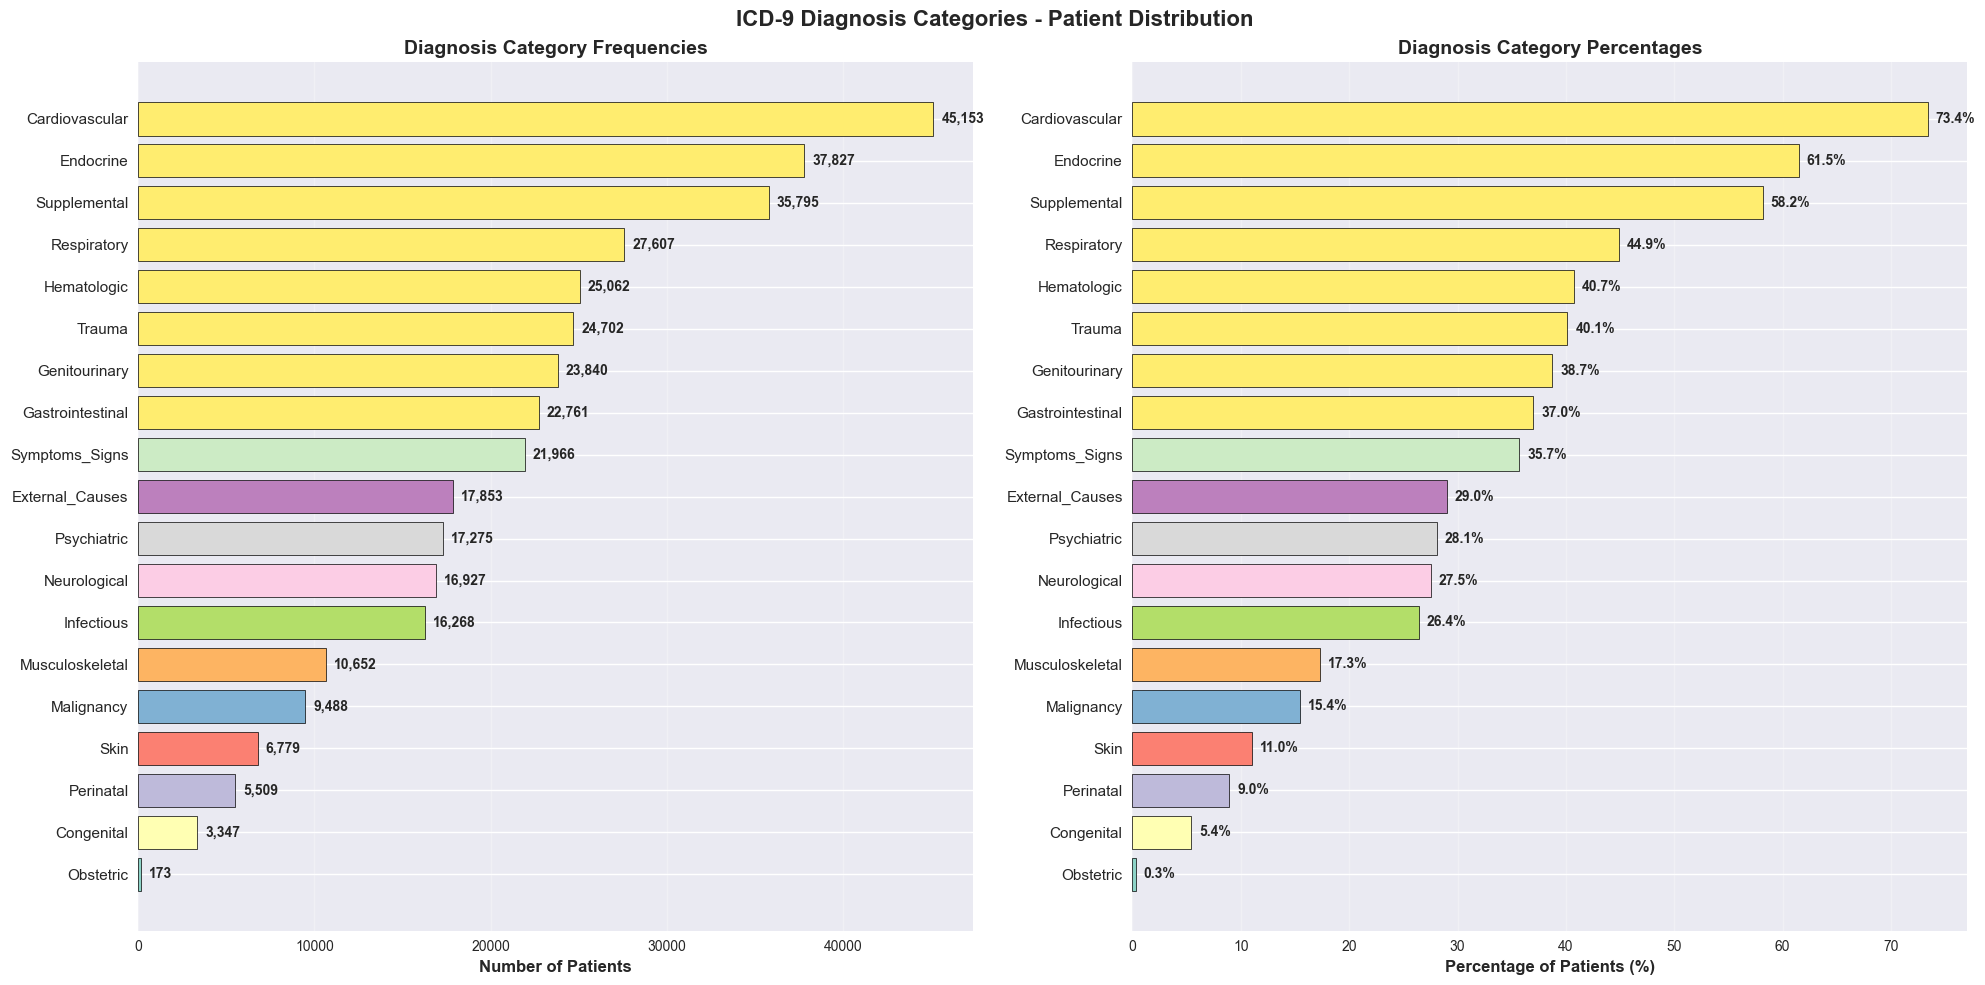


DIAGNOSIS CATEGORY SUMMARY
Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)
Average patients per category: 19420
Median patients per category: 17853

Top 5 Most Common Categories:
  Hematologic: 25,062 patients (40.7%)
  Respiratory: 27,607 patients (44.9%)
  Supplemental: 35,795 patients (58.2%)
  Endocrine: 37,827 patients (61.5%)
  Cardiovascular: 45,153 patients (73.4%)

Bottom 5 Least Common Categories:
  Obstetric: 173 patients (0.3%)
  Congenital: 3,347 patients (5.4%)
  Perinatal: 5,509 patients (9.0%)
  Skin: 6,779 patients (11.0%)
  Malignancy: 9,488 patients (15.4%)


In [36]:
# Usage example:
category_data = visualize_diagnosis_categories(diagnosis_bins_patient)

Extracting diagnosis category frequencies...


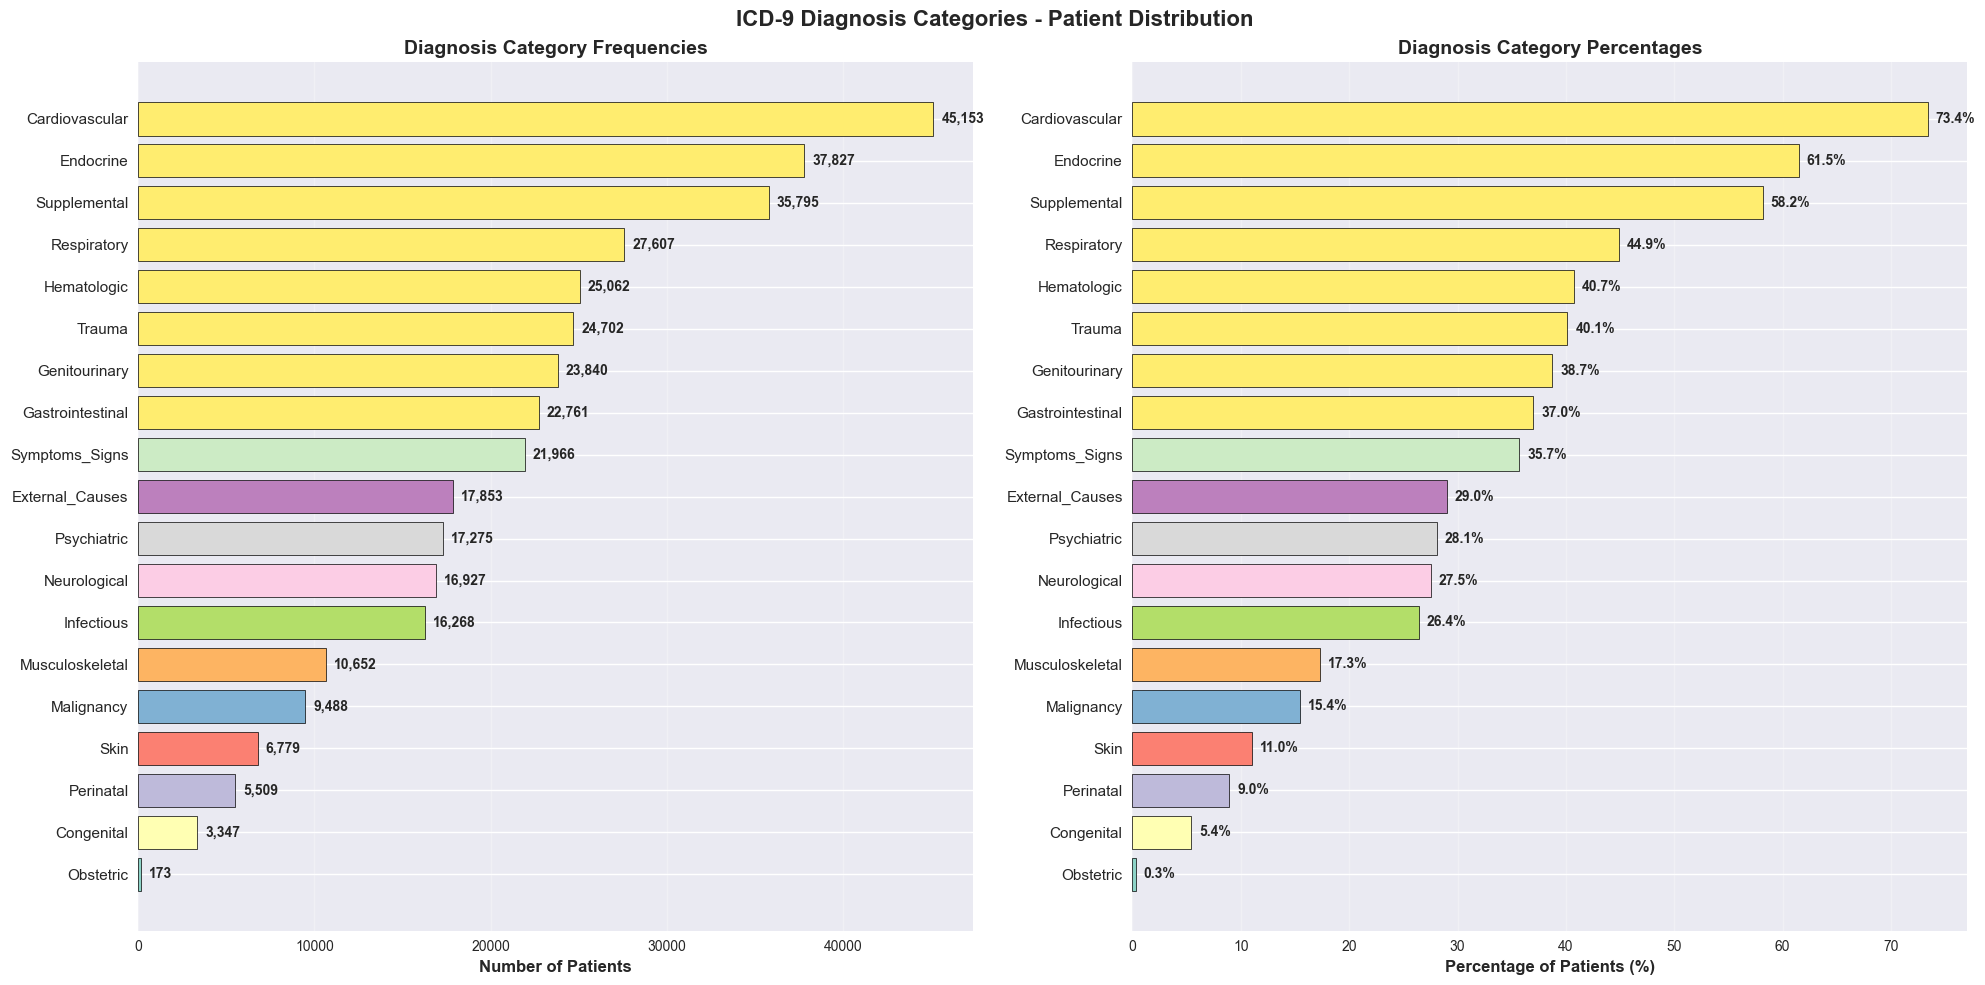


DIAGNOSIS CATEGORY SUMMARY
Total ICU patients analyzed: 61,532
Most common diagnosis category: Cardiovascular (73.4%)
Least common diagnosis category: Obstetric (0.3%)
Average patients per category: 19420
Median patients per category: 17853

Top 5 Most Common Categories:
  Hematologic: 25,062 patients (40.7%)
  Respiratory: 27,607 patients (44.9%)
  Supplemental: 35,795 patients (58.2%)
  Endocrine: 37,827 patients (61.5%)
  Cardiovascular: 45,153 patients (73.4%)

Bottom 5 Least Common Categories:
  Obstetric: 173 patients (0.3%)
  Congenital: 3,347 patients (5.4%)
  Perinatal: 5,509 patients (9.0%)
  Skin: 6,779 patients (11.0%)
  Malignancy: 9,488 patients (15.4%)


In [65]:
cateogry_data_fixed = visualize_diagnosis_categories(diagnosis_bins_patient_fixed)

In [37]:
summary_table = create_diagnosis_summary_table(diagnosis_bins_patient)


DETAILED DIAGNOSIS CATEGORY BREAKDOWN
Diagnosis Category ICD-9 Code Range Patient Count Percentage
    Cardiovascular          390-459        45,153      73.4%
         Endocrine          240-279        37,827      61.5%
      Supplemental          V codes        35,795      58.2%
       Respiratory          460-519        27,607      44.9%
       Hematologic          280-289        25,062      40.7%
            Trauma          800-999        24,702      40.1%
     Genitourinary          580-629        23,840      38.7%
  Gastrointestinal          520-579        22,761      37.0%
    Symptoms Signs          780-799        21,966      35.7%
   External Causes          E codes        17,853      29.0%
       Psychiatric          290-319        17,275      28.1%
      Neurological          320-389        16,927      27.5%
        Infectious          001-139        16,268      26.4%
   Musculoskeletal          710-739        10,652      17.3%
        Malignancy          140-239         9,

<b> CHART EVENTS and D_ITEMS join </b>

In [38]:
chart_events_df.show(5)

+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|        36| 165660|    241249|223834|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|   15|    15.0|   L/min|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|223835|2134-05-12 12:00:00|2134-05-12 13:56:00|17525|  100|   100.0|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224328|2134-05-12 12:00:00|2134-05-12 12:18:00|20823|  .37|    0.37|    NULL|      0|    0|        NULL|   NULL|
|        36| 165660|    241249|224329|2134-05-12 12:00:00|2134-05-12 12:19:00|20823|    6|     6.0|     min|      0|    0|        NULL| 

In [39]:
d_items_df.show(5)

+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|ITEMID|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
|   497|Patient controlle...|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   498|   PCA Lockout (Min)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   499|      PCA Medication|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   500|      PCA Total Dose|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
|   501|  PCV Exh Vt (Obser)|        NULL| carevue|chartevents|    NULL|    NULL|      NULL|     NULL|
+------+--------------------+------------+--------+-----------+--------+--------+----------+---------+
only showing top 5 rows



<b> Check different databases for ChartEvents </b>

In [40]:
d_items_df.select("DBSOURCE").distinct().show()

+----------+
|  DBSOURCE|
+----------+
|   carevue|
|  hospital|
|metavision|
+----------+



In [44]:
chartevents_item_d_items = chart_events_df.join(d_items_df, on=["ITEMID"], how="left")

In [48]:
# See the database split
chartevents_dbsource_dist = chart_events_df.join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE").count() \
    .orderBy(desc("count"))
chartevents_dbsource_dist.show()

+----------+---------+
|  DBSOURCE|    count|
+----------+---------+
|   carevue|221315841|
|metavision|109396642|
+----------+---------+



In [49]:
# Check patient distribution across databases
patient_db_dist = chart_events_df.join(d_items_df, on="ITEMID") \
    .select("SUBJECT_ID", "DBSOURCE").distinct() \
    .groupBy("DBSOURCE").count()
patient_db_dist.show()

+----------+-----+
|  DBSOURCE|count|
+----------+-----+
|   carevue|30658|
|metavision|19685|
+----------+-----+



In [50]:
# Only ICU chartevents - filter where ICUSTAY_ID is not null
icu_chartevents = chart_events_df.filter(col("ICUSTAY_ID").isNotNull())

In [51]:
# Check database distribution for ICU chartevents only
icu_chartevents_db_dist = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df, on="ITEMID") \
    .groupBy("DBSOURCE").count() \
    .orderBy(desc("count"))
icu_chartevents_db_dist.show()

+----------+---------+
|  DBSOURCE|    count|
+----------+---------+
|   carevue|221054208|
|metavision|109360746|
+----------+---------+



In [ ]:
# Filter to CareVue ICU chartevents only
icu_chartevents_carevue = chart_events_df.filter(col("ICUSTAY_ID").isNotNull()) \
    .join(d_items_df.filter(col("DBSOURCE") == "carevue"), on="ITEMID")

print(f"Filtered dataset: {icu_chartevents_carevue.count()} records")
print(f"Unique ICU stays: {icu_chartevents_carevue.select('ICUSTAY_ID').distinct().count()}")

Filtered dataset: 221054208 records


Unique ICU stays: 37945


In [67]:
icu_chartevents_carevue.show()

+------+----------+-------+----------+-------------------+-------------------+-----+----------------+--------+--------+-------+-----+------------+--------+--------------------+------------+--------+-----------+----------+--------+----------+---------+
|ITEMID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|          CHARTTIME|          STORETIME| CGID|           VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS| STOPPED|               LABEL|ABBREVIATION|DBSOURCE|    LINKSTO|  CATEGORY|UNITNAME|PARAM_TYPE|CONCEPTID|
+------+----------+-------+----------+-------------------+-------------------+-----+----------------+--------+--------+-------+-----+------------+--------+--------------------+------------+--------+-----------+----------+--------+----------+---------+
|   861|         3| 145834|    211552|2101-10-25 03:00:00|2101-10-25 04:09:00|15331|            10.7|    10.7|    NULL|   NULL| NULL|       Final|NotStopd|      WBC (4-11,000)|        NULL| carevue|chartevents|Hematology|    NULL|      NULL|   

In [71]:
#full_icu_info_chart_events = icu_chartevents_carevue.join(diagnosis_bins_patient_fixed, how="left", on="SUBJECT_ID")

<b> Check unique patients count </b>

In [ ]:
diagnosis_bins_patient_fixed.select("ICUSTAY_ID").distinct().count()

46476

In [86]:
icu_chartevents_carevue.select("ICUSTAY_ID").distinct().count()

37945

In [ ]:
full_icu_info_chart_events = diagnosis_bins_patient_fixed.join(icu_chartevents_carevue, how="left", on = "SUBJECT_ID")

In [83]:
full_icu_info_chart_events.select("SUBJECT_ID").distinct().count()

46476

In [69]:
full_icu_info_chart_events.show()

+----------+------+-------+----------+-------------------+-------------------+-----+------------------+-----------------+--------+-------+-----+------------+--------+--------------------+------------+--------+-----------+--------+--------+----------+---------+----------+-------+--------+--------------+-------------+------------+-----------+-------------------+-------------------+-------+-------------------+-------------------+---------+--------------+--------------------+--------------------+---------+--------+--------+--------------+--------------------+-------------------+-------------------+-------------+--------------------+--------------------+------+-------------------+----+-----------+--------------+--------------+-------------+---------------+---------------+----------------+------------------+---------------+--------------------+-----------------+-------------+--------+-------------------+--------------+-------------+------------------+----------+-------------------+----------

In [87]:
# Only keep ICU stays that have CareVue data
chartevents_icustays_list = [row.ICUSTAY_ID for row in icu_chartevents_carevue.select("ICUSTAY_ID").distinct().collect()]
diagnosis_filtered = diagnosis_bins_patient_fixed.filter(col("ICUSTAY_ID").isin(chartevents_icustays_list))

In [88]:
diagnosis_filtered.select("ICUSTAY_ID").distinct().count()

25/06/03 20:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1149.4 KiB
25/06/03 20:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1159.1 KiB


37945

<b> Notas: </b>

* Okay haver várias entradas na ICU para 1 mesmo paciente <b> (DONE) </b>

* Corrigir vários diagnósticos para mesma entrada na ICU:
    * dividir em várias features os diagnóticos (dividir por tipo de diagnóstico para  a mesma entrada ICU) <b> (OPTEI POR ISTO) </b>
    * usar o diagnóstico principal (SEQ_NUM = 1)

* Ao juntar CHART_EVENTS com D_ITEMS:
    * Provavelmente mais útil usar 1 só database (dbsource - CareVue or Metavision), porque há medições dos mesmos sinais vitais nas duas bases de dados
        * Ver qual apresenta mais medições (volume de dados) <b> (A IMPLEMENTAR) </b>


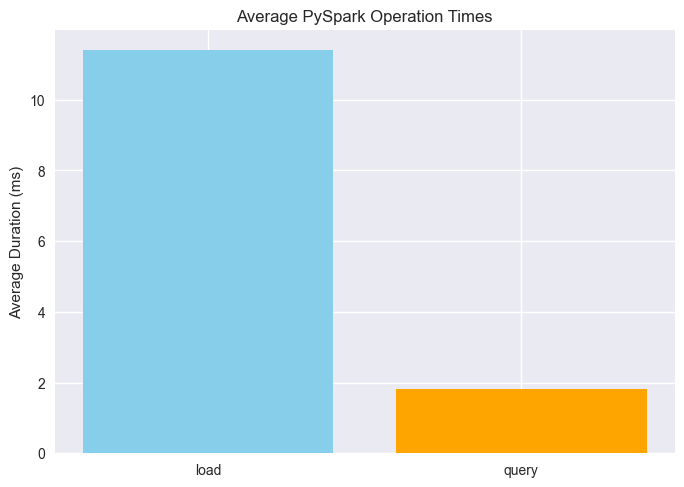

In [ ]:
'''
def benchmark_query(patients_full_info_df, time_markings_spark):
    start_time = time.time()

    for i in range(10):
        # Trigger action without showing output (to materialize the computation)
        patients_full_info_df.count()

    end_time = time.time()
    totalTime = end_time - start_time



    # Record the total benchmarking time
    time_markings_spark["query"].append(totalTime)


#funtion to graph by the average of each BQ operation
def graphavg(time_markings_spark):
    # Calculate averages
    avg_times = {
        op: sum(times)/len(times) if times else 0
        for op, times in time_markings_spark.items()
    }

    # Prepare data for plotting
    operations = list(avg_times.keys())
    averages = list(avg_times.values())

    # Plot
    plt.bar(operations, averages, color=["skyblue", "orange", "green"])
    plt.ylabel("Average Duration (ms)")
    plt.title("Average PySpark Operation Times")
    plt.show()


benchmark_query(patients_full_info_df, time_markings_spark)
graphavg(time_markings_spark)
'''

<b> A PARTIR DAQUI É EXPERIMENTAL NÃO CORRER NA GCP </b>

In [56]:
'''
def create_comprehensive_diagnosis_features(patients_full_info_df):
    """
    Create comprehensive diagnosis features with maximum coverage.
    """
    print("Creating comprehensive diagnosis features with maximum coverage...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Comprehensive diagnosis categories with broader patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("LONG_TITLE").rlike("(?i)(pregnancy|obstetric|delivery|labor|fetal|maternal|cesarean|abortion|miscarriage)"), 1).otherwise(0)) \
        .withColumn("has_ophthalmologic", 
                   when(col("LONG_TITLE").rlike("(?i)(eye|vision|retinal|glaucoma|cataract|visual|optic|corneal)"), 1).otherwise(0)) \
        .withColumn("has_otolaryngologic", 
                   when(col("LONG_TITLE").rlike("(?i)(ear|nose|throat|hearing|sinus|tonsil|pharyngeal|laryngeal)"), 1).otherwise(0)) \
        .withColumn("has_nutritional", 
                   when(col("LONG_TITLE").rlike("(?i)(nutrition|vitamin|deficiency|malnutrition|obesity|feeding)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_surgical").alias("has_surgical"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_ophthalmologic").alias("has_ophthalmologic"),
            spark_max("has_otolaryngologic").alias("has_otolaryngologic"),
            spark_max("has_nutritional").alias("has_nutritional"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                     "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                     "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                     "has_musculoskeletal", "has_skin", "has_genitourinary", "has_obstetric",
                     "has_ophthalmologic", "has_otolaryngologic", "has_nutritional", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"Comprehensive diagnosis features created: {result.count()} rows")
    return result
'''

'''
def create_comprehensive_diagnosis_features(patients_full_info_df):
    """
    Create comprehensive diagnosis features with maximum coverage.
    """
    print("Creating comprehensive diagnosis features with maximum coverage...")
    
    # Get base data without diagnoses
    base_cols = [col_name for col_name in patients_full_info_df.columns 
                 if col_name not in ["ICD9_CODE", "LONG_TITLE", "SEQ_NUM"]]
    base_data = patients_full_info_df.select(*base_cols).distinct()
    
    # Comprehensive diagnosis categories with broader patterns
    diagnosis_features = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("LONG_TITLE").rlike("(?i)(pregnancy|obstetric|delivery|labor|fetal|maternal|cesarean|abortion|miscarriage)"), 1).otherwise(0)) \
        .withColumn("has_ophthalmologic", 
                   when(col("LONG_TITLE").rlike("(?i)(eye|vision|retinal|glaucoma|cataract|visual|optic|corneal)"), 1).otherwise(0)) \
        .withColumn("has_otolaryngologic", 
                   when(col("LONG_TITLE").rlike("(?i)(ear|nose|throat|hearing|sinus|tonsil|pharyngeal|laryngeal)"), 1).otherwise(0)) \
        .withColumn("has_nutritional", 
                   when(col("LONG_TITLE").rlike("(?i)(nutrition|vitamin|deficiency|malnutrition|obesity|feeding)"), 1).otherwise(0)) \
        .groupBy("ICUSTAY_ID") \
        .agg(
            spark_max("has_cardiovascular").alias("has_cardiovascular"),
            spark_max("has_respiratory").alias("has_respiratory"), 
            spark_max("has_renal").alias("has_renal"),
            spark_max("has_infectious").alias("has_infectious"),
            spark_max("has_endocrine").alias("has_endocrine"),
            spark_max("has_neurological").alias("has_neurological"),
            spark_max("has_trauma").alias("has_trauma"),
            spark_max("has_gastrointestinal").alias("has_gastrointestinal"),
            spark_max("has_hematologic").alias("has_hematologic"),
            spark_max("has_malignancy").alias("has_malignancy"),
            spark_max("has_psychiatric").alias("has_psychiatric"),
            spark_max("has_surgical").alias("has_surgical"),
            spark_max("has_musculoskeletal").alias("has_musculoskeletal"),
            spark_max("has_skin").alias("has_skin"),
            spark_max("has_genitourinary").alias("has_genitourinary"),
            spark_max("has_obstetric").alias("has_obstetric"),
            spark_max("has_ophthalmologic").alias("has_ophthalmologic"),
            spark_max("has_otolaryngologic").alias("has_otolaryngologic"),
            spark_max("has_nutritional").alias("has_nutritional"),
            count("ICD9_CODE").alias("total_diagnoses")
        )
    
    # Join with base data and fill nulls
    result = base_data.join(diagnosis_features, on="ICUSTAY_ID", how="left")
    
    # Fill nulls with 0 for diagnosis features
    diagnosis_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                     "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                     "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                     "has_musculoskeletal", "has_skin", "has_genitourinary", "has_obstetric",
                     "has_ophthalmologic", "has_otolaryngologic", "has_nutritional", "total_diagnoses"]
    
    for col_name in diagnosis_cols:
        result = result.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    
    print(f"Comprehensive diagnosis features created: {result.count()} rows")

    return result'''

''' 
def test_comprehensive_diagnosis_coverage(patients_full_info_df):
    """
    Test how many unique diagnosis codes are covered by the comprehensive clinical categories.
    """
    print("=== TESTING COMPREHENSIVE DIAGNOSIS COVERAGE ===")
    
    # Get all unique diagnosis codes
    all_codes = patients_full_info_df.filter(col("ICD9_CODE").isNotNull()) \
        .select("ICD9_CODE", "LONG_TITLE").distinct()
    
    total_unique_codes = all_codes.count()
    print(f"Total unique diagnosis codes: {total_unique_codes}")
    
    # Test each diagnosis against all categories
    test_df = all_codes
    
    # Apply the same logic as in your main function
    test_df = test_df \
        .withColumn("has_cardiovascular", 
                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0)) \
        .withColumn("has_respiratory", 
                   when(col("LONG_TITLE").rlike("(?i)(respiratory|pneumonia|copd|lung|asthma|bronch|pleural|dyspnea|hypoxia|ventilat|pulmonary|trachea|larynx|pharynx|cough|apnea)"), 1).otherwise(0)) \
        .withColumn("has_renal", 
                   when(col("LONG_TITLE").rlike("(?i)(renal|kidney|nephritis|dialysis|uremia|creatinine|acute kidney|chronic kidney|glomerular|proteinuria|hematuria|bladder)"), 1).otherwise(0)) \
        .withColumn("has_infectious", 
                   when(col("LONG_TITLE").rlike("(?i)(sepsis|septic|infection|abscess|cellulitis|endocarditis|meningitis|peritonitis|bacteremia|pneumococcal|staphylococcal|streptococcal|viral|fungal)"), 1).otherwise(0)) \
        .withColumn("has_endocrine", 
                   when(col("LONG_TITLE").rlike("(?i)(diabetes|diabetic|thyroid|adrenal|hormone|insulin|glucose|ketoacidosis|hypoglycemia|hyperglycemia|metabolic|electrolyte)"), 1).otherwise(0)) \
        .withColumn("has_neurological", 
                   when(col("LONG_TITLE").rlike("(?i)(stroke|cerebral|brain|neurologic|seizure|coma|encephalopathy|hemorrhage|ischemia|paralysis|paresis|dementia|alzheimer)"), 1).otherwise(0)) \
        .withColumn("has_trauma", 
                   when(col("LONG_TITLE").rlike("(?i)(trauma|fracture|injury|accident|burn|laceration|contusion|wound|dislocation|sprain|crushing)"), 1).otherwise(0)) \
        .withColumn("has_gastrointestinal", 
                   when(col("LONG_TITLE").rlike("(?i)(gastrointestinal|liver|hepatic|pancrea|gallbladder|bowel|intestinal|gastric|duodenal|bleeding|obstruction|colitis|gastritis|ulcer)"), 1).otherwise(0)) \
        .withColumn("has_hematologic", 
                   when(col("LONG_TITLE").rlike("(?i)(anemia|blood|coagulation|bleeding|thrombocytopenia|leukemia|lymphoma|transfusion|hemoglobin|platelet|clotting)"), 1).otherwise(0)) \
        .withColumn("has_malignancy", 
                   when(col("LONG_TITLE").rlike("(?i)(cancer|malignant|neoplasm|tumor|carcinoma|metastatic|oncology|sarcoma|melanoma|lymphoma|leukemia)"), 1).otherwise(0)) \
        .withColumn("has_psychiatric", 
                   when(col("LONG_TITLE").rlike("(?i)(depression|anxiety|psychosis|delirium|substance|alcohol|drug|overdose|bipolar|schizophrenia|suicidal)"), 1).otherwise(0)) \
        .withColumn("has_surgical", 
                   when(col("LONG_TITLE").rlike("(?i)(post.surgical|post.operative|surgical|operation|procedure|complication|postoperative|anastomosis)"), 1).otherwise(0)) \
        .withColumn("has_musculoskeletal", 
                   when(col("LONG_TITLE").rlike("(?i)(arthritis|joint|bone|muscle|tendon|ligament|osteo|rheumat|fibromyalgia|gout|skeletal)"), 1).otherwise(0)) \
        .withColumn("has_skin", 
                   when(col("LONG_TITLE").rlike("(?i)(skin|dermat|rash|eczema|psoriasis|ulcer|decubitus|pressure sore|cellulitis)"), 1).otherwise(0)) \
        .withColumn("has_genitourinary", 
                   when(col("LONG_TITLE").rlike("(?i)(urinary|genital|prostate|ovarian|uterine|testicular|menstrual|reproductive)"), 1).otherwise(0)) \
        .withColumn("has_obstetric", 
                   when(col("LONG_TITLE").rlike("(?i)(pregnancy|obstetric|delivery|labor|fetal|maternal|cesarean|abortion|miscarriage)"), 1).otherwise(0)) \
        .withColumn("has_ophthalmologic", 
                   when(col("LONG_TITLE").rlike("(?i)(eye|vision|retinal|glaucoma|cataract|visual|optic|corneal)"), 1).otherwise(0)) \
        .withColumn("has_otolaryngologic", 
                   when(col("LONG_TITLE").rlike("(?i)(ear|nose|throat|hearing|sinus|tonsil|pharyngeal|laryngeal)"), 1).otherwise(0)) \
        .withColumn("has_nutritional", 
                   when(col("LONG_TITLE").rlike("(?i)(nutrition|vitamin|deficiency|malnutrition|obesity|feeding)"), 1).otherwise(0))
    
    # Create a column that indicates if ANY category matches
    category_cols = ["has_cardiovascular", "has_respiratory", "has_renal", "has_infectious", 
                    "has_endocrine", "has_neurological", "has_trauma", "has_gastrointestinal",
                    "has_hematologic", "has_malignancy", "has_psychiatric", "has_surgical", 
                    "has_musculoskeletal", "has_skin", "has_genitourinary", "has_obstetric",
                    "has_ophthalmologic", "has_otolaryngologic", "has_nutritional"]
    
    # Sum all category columns to see if any diagnosis is covered
    test_df = test_df.withColumn("covered", 
                                sum([col(category) for category in category_cols]))
    
    # Count how many codes are covered (covered > 0)
    covered_codes = test_df.filter(col("covered") > 0).count()
    uncovered_codes = test_df.filter(col("covered") == 0).count()
    
    coverage_percentage = (covered_codes / total_unique_codes) * 100
    
    print(f"=== COMPREHENSIVE COVERAGE RESULTS ===")
    print(f"Unique diagnosis codes covered: {covered_codes:,} out of {total_unique_codes:,}")
    print(f"Coverage percentage: {coverage_percentage:.1f}%")
    print(f"Uncovered codes: {uncovered_codes:,}")
    
    # Show breakdown by category
    print("\n=== COVERAGE BY CATEGORY ===")
    for category in category_cols:
        category_count = test_df.filter(col(category) == 1).count()
        print(f"{category}: {category_count:,} codes")
    
    # Show some uncovered examples
    print("\n=== SAMPLE UNCOVERED DIAGNOSES ===")
    uncovered_sample = test_df.filter(col("covered") == 0) \
        .select("ICD9_CODE", "LONG_TITLE") \
        .limit(15)
    uncovered_sample.show(truncate=False)
    
    return coverage_percentage

# Test the comprehensive coverage
coverage = test_comprehensive_diagnosis_coverage(patients_full_info_df)'''

' \ndef test_comprehensive_diagnosis_coverage(patients_full_info_df):\n    """\n    Test how many unique diagnosis codes are covered by the comprehensive clinical categories.\n    """\n    print("=== TESTING COMPREHENSIVE DIAGNOSIS COVERAGE ===")\n\n    # Get all unique diagnosis codes\n    all_codes = patients_full_info_df.filter(col("ICD9_CODE").isNotNull())         .select("ICD9_CODE", "LONG_TITLE").distinct()\n\n    total_unique_codes = all_codes.count()\n    print(f"Total unique diagnosis codes: {total_unique_codes}")\n\n    # Test each diagnosis against all categories\n    test_df = all_codes\n\n    # Apply the same logic as in your main function\n    test_df = test_df         .withColumn("has_cardiovascular", \n                   when(col("LONG_TITLE").rlike("(?i)(cardiac|heart|myocardial|coronary|arrhythmia|atrial|ventricular|valve|aortic|mitral|chest pain|angina|hypertension|blood pressure|pericardial|endocardial)"), 1).otherwise(0))         .withColumn("has_respiratory", \n  

In [57]:
'''
def create_filtered_chartevents_with_items(chart_events_df, d_items_df, target_categories=None):
    """
    Filter and join CHARTEVENTS with D_ITEMS strategically.
    """
    print("Creating filtered CHARTEVENTS with D_ITEMS...")
    
    # Step 1: Filter D_ITEMS to only vital signs and key measurements
    if target_categories is None:
        target_categories = [
            "Vital Signs", "Cardiovascular", "Respiratory", 
            "Neurological", "Blood Gas", "Chemistry"
        ]
    
    # Get relevant ITEMIDs first
    relevant_items = d_items_df.filter(
        col("CATEGORY").rlike("|".join([f"(?i){cat}" for cat in target_categories]))
    )
    
    print(f"Filtered D_ITEMS from {d_items_df.count()} to {relevant_items.count()} relevant items")
    
    # Step 2: Get list of ITEMIDs to filter CHARTEVENTS
    relevant_itemids = relevant_items.select("ITEMID").rdd.flatMap(lambda x: x).collect()
    
    print(f"Found {len(relevant_itemids)} relevant ITEMIDs")
    
    # Step 3: Filter CHARTEVENTS to only relevant ITEMIDs (major performance boost)
    filtered_chartevents = chart_events_df.filter(col("ITEMID").isin(relevant_itemids))
    
    original_count = chart_events_df.count()
    filtered_count = filtered_chartevents.count()
    print(f"Filtered CHARTEVENTS from {original_count:,} to {filtered_count:,} rows")
    
    # Step 4: Now join the filtered data
    chartevents_with_items = filtered_chartevents.join(relevant_items, on="ITEMID", how="left")
    
    print(f"Final joined dataset: {chartevents_with_items.count():,} rows")
    return chartevents_with_items, relevant_items

# Execute the filtering approach
chartevents_filtered, items_dict = create_filtered_chartevents_with_items(
    chart_events_df, 
    d_items_df,
    target_categories=["Vital Signs", "Cardiovascular", "Respiratory"]
)
'''

'\ndef create_filtered_chartevents_with_items(chart_events_df, d_items_df, target_categories=None):\n    """\n    Filter and join CHARTEVENTS with D_ITEMS strategically.\n    """\n    print("Creating filtered CHARTEVENTS with D_ITEMS...")\n\n    # Step 1: Filter D_ITEMS to only vital signs and key measurements\n    if target_categories is None:\n        target_categories = [\n            "Vital Signs", "Cardiovascular", "Respiratory", \n            "Neurological", "Blood Gas", "Chemistry"\n        ]\n\n    # Get relevant ITEMIDs first\n    relevant_items = d_items_df.filter(\n        col("CATEGORY").rlike("|".join([f"(?i){cat}" for cat in target_categories]))\n    )\n\n    print(f"Filtered D_ITEMS from {d_items_df.count()} to {relevant_items.count()} relevant items")\n\n    # Step 2: Get list of ITEMIDs to filter CHARTEVENTS\n    relevant_itemids = relevant_items.select("ITEMID").rdd.flatMap(lambda x: x).collect()\n\n    print(f"Found {len(relevant_itemids)} relevant ITEMIDs")\n\n    #

In [58]:
'''
def create_focused_vital_signs_data(chart_events_df, d_items_df, dbsource="metavision"):
    """
    Create a focused dataset with specific vital signs from one database source.
    """
    print(f"Creating focused vital signs data from {dbsource}...")
    
    # Define the vital signs you actually need
    vital_signs_mapping = {
        'Heart Rate': ['heart rate', 'hr'],
        'Blood Pressure Systolic': ['systolic', 'sbp', 'arterial bp sys'],
        'Blood Pressure Diastolic': ['diastolic', 'dbp', 'arterial bp [d]'],
        'Blood Pressure Mean': ['mean bp', 'mbp', 'arterial bp mean'],
        'Respiratory Rate': ['respiratory rate', 'resp rate'],
        'Temperature': ['temperature', 'temp'],
        'SpO2': ['spo2', 'o2 sat'],
        'Glasgow Coma Scale': ['gcs', 'glasgow']
    }
    
    # Get specific ITEMIDs for each vital sign from chosen database
    vital_itemids = {}
    
    for vital_name, search_terms in vital_signs_mapping.items():
        # Create regex pattern for this vital sign
        pattern = "|".join([f"(?i){term}" for term in search_terms])
        
        # Find ITEMIDs for this vital sign from specific database
        items = d_items_df.filter(
            (col("DBSOURCE") == dbsource) &
            col("LABEL").rlike(pattern)
        ).select("ITEMID", "LABEL", "UNITNAME")
        
        itemids = items.select("ITEMID").rdd.flatMap(lambda x: x).collect()
        vital_itemids[vital_name] = itemids
        
        print(f"{vital_name}: {itemids}")
        if itemids:  # Show what labels we found
            items.show(truncate=False)
    
    # Collect all ITEMIDs we want to keep
    all_target_itemids = []
    for itemids in vital_itemids.values():
        all_target_itemids.extend(itemids)
    
    print(f"Total target ITEMIDs: {len(all_target_itemids)}")
    
    # Filter CHARTEVENTS to only these specific measurements
    focused_chartevents = chart_events_df.filter(col("ITEMID").isin(all_target_itemids))
    
    # Join with D_ITEMS for labels
    focused_with_labels = focused_chartevents.join(
        d_items_df.select("ITEMID", "LABEL", "CATEGORY", "UNITNAME"), 
        on="ITEMID", 
        how="left"
    )
    
    print(f"Focused dataset: {focused_with_labels.count():,} rows")
    return focused_with_labels, vital_itemids

# Execute focused approach
focused_data, vital_mapping = create_focused_vital_signs_data(
    chart_events_df, 
    d_items_df, 
    dbsource="metavision"
)
'''

'\ndef create_focused_vital_signs_data(chart_events_df, d_items_df, dbsource="metavision"):\n    """\n    Create a focused dataset with specific vital signs from one database source.\n    """\n    print(f"Creating focused vital signs data from {dbsource}...")\n\n    # Define the vital signs you actually need\n    vital_signs_mapping = {\n        \'Heart Rate\': [\'heart rate\', \'hr\'],\n        \'Blood Pressure Systolic\': [\'systolic\', \'sbp\', \'arterial bp sys\'],\n        \'Blood Pressure Diastolic\': [\'diastolic\', \'dbp\', \'arterial bp [d]\'],\n        \'Blood Pressure Mean\': [\'mean bp\', \'mbp\', \'arterial bp mean\'],\n        \'Respiratory Rate\': [\'respiratory rate\', \'resp rate\'],\n        \'Temperature\': [\'temperature\', \'temp\'],\n        \'SpO2\': [\'spo2\', \'o2 sat\'],\n        \'Glasgow Coma Scale\': [\'gcs\', \'glasgow\']\n    }\n\n    # Get specific ITEMIDs for each vital sign from chosen database\n    vital_itemids = {}\n\n    for vital_name, search_term

In [59]:
'''
def create_analysis_ready_vitals(chart_events_df, d_items_df, icustays_df, 
                                window_hours=24, dbsource="metavision"):
    """
    Create analysis-ready vital signs data with time windowing and patient filtering.
    """
    print("Creating analysis-ready vital signs data...")
    
    # Step 1: Get your target ICU stays
    target_icustays = icustays_df.select("ICUSTAY_ID", "INTIME")
    
    # Step 2: Get focused vital signs ITEMIDs
    focused_data, vital_mapping = create_focused_vital_signs_data(
        chart_events_df, 
        d_items_df, 
        dbsource=dbsource
    )
    
    # Step 3: Filter to your ICU stays and time window
    analysis_data = focused_data.join(target_icustays, on="ICUSTAY_ID") \
        .filter(
            (col("CHARTTIME") >= col("INTIME")) &
            (col("CHARTTIME") <= expr(f"INTIME + INTERVAL {window_hours} HOURS")) &
            col("VALUENUM").isNotNull() &
            (col("VALUENUM") > 0)
        )
    
    print(f"Analysis-ready data: {analysis_data.count():,} rows")
    
    # Step 4: Apply clinical bounds to remove outliers
    analysis_data = apply_clinical_bounds_with_labels(analysis_data)
    
    return analysis_data, vital_mapping

def apply_clinical_bounds_with_labels(df):
    """Apply clinical bounds based on the measurement labels."""
    # Heart rate bounds
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)heart.rate") & 
             ((col("VALUENUM") < 20) | (col("VALUENUM") > 300)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Blood pressure bounds
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)(systolic|diastolic|mean)") & 
             ((col("VALUENUM") < 30) | (col("VALUENUM") > 300)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Temperature bounds (assuming Celsius)
    df = df.withColumn("VALUENUM",
        when(col("LABEL").rlike("(?i)temperature") & 
             ((col("VALUENUM") < 30) | (col("VALUENUM") > 45)), None)
        .otherwise(col("VALUENUM"))
    )
    
    # Remove null values after bounds checking
    df = df.filter(col("VALUENUM").isNotNull())
    
    return df

# Execute the complete pipeline
analysis_ready_data, vitals_mapping = create_analysis_ready_vitals(
    chart_events_df, 
    d_items_df, 
    icustays_df,
    window_hours=24,
    dbsource="metavision"
)'''

'\ndef create_analysis_ready_vitals(chart_events_df, d_items_df, icustays_df, \n                                window_hours=24, dbsource="metavision"):\n    """\n    Create analysis-ready vital signs data with time windowing and patient filtering.\n    """\n    print("Creating analysis-ready vital signs data...")\n\n    # Step 1: Get your target ICU stays\n    target_icustays = icustays_df.select("ICUSTAY_ID", "INTIME")\n\n    # Step 2: Get focused vital signs ITEMIDs\n    focused_data, vital_mapping = create_focused_vital_signs_data(\n        chart_events_df, \n        d_items_df, \n        dbsource=dbsource\n    )\n\n    # Step 3: Filter to your ICU stays and time window\n    analysis_data = focused_data.join(target_icustays, on="ICUSTAY_ID")         .filter(\n            (col("CHARTTIME") >= col("INTIME")) &\n            (col("CHARTTIME") <= expr(f"INTIME + INTERVAL {window_hours} HOURS")) &\n            col("VALUENUM").isNotNull() &\n            (col("VALUENUM") > 0)\n        )\n\

In [60]:
'''def create_vital_features_from_joined_data(analysis_data, vitals_mapping):
    """
    Create final vital sign features from the joined and filtered data.
    """
    print("Creating final vital sign features...")
    
    # Create features for each vital sign category
    all_features = None
    
    for vital_name, itemids in vitals_mapping.items():
        if not itemids:
            continue
            
        print(f"Processing {vital_name}...")
        
        # Filter to this vital sign
        vital_data = analysis_data.filter(col("ITEMID").isin(itemids))
        
        # Create aggregated features
        vital_features = vital_data.groupBy("ICUSTAY_ID").agg(
            avg("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_mean"),
            min("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_min"),
            max("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_max"),
            stddev("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_std"),
            count("VALUENUM").alias(f"{vital_name.lower().replace(' ', '_')}_count")
        )
        
        # Join features
        if all_features is None:
            all_features = vital_features
        else:
            all_features = all_features.join(vital_features, on="ICUSTAY_ID", how="outer")
    
    print(f"Created features for {all_features.count()} ICU stays")
    return all_features

# Create final features
final_vital_features = create_vital_features_from_joined_data(analysis_ready_data, vitals_mapping)

# Join with your main patient data
patients_with_vitals = patients_full_info_fixed.join(
    final_vital_features, 
    on="ICUSTAY_ID", 
    how="left"
)'''

'def create_vital_features_from_joined_data(analysis_data, vitals_mapping):\n    """\n    Create final vital sign features from the joined and filtered data.\n    """\n    print("Creating final vital sign features...")\n\n    # Create features for each vital sign category\n    all_features = None\n\n    for vital_name, itemids in vitals_mapping.items():\n        if not itemids:\n            continue\n\n        print(f"Processing {vital_name}...")\n\n        # Filter to this vital sign\n        vital_data = analysis_data.filter(col("ITEMID").isin(itemids))\n\n        # Create aggregated features\n        vital_features = vital_data.groupBy("ICUSTAY_ID").agg(\n            avg("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_mean"),\n            min("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_min"),\n            max("VALUENUM").alias(f"{vital_name.lower().replace(\' \', \'_\')}_max"),\n            stddev("VALUENUM").alias(f"{vital_name.lower().replace(\' \